In [54]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_ode, plot_losses, l2
from modules.problems import DampedHarmonicOscillator

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def train(
    problem,
    model,
    coef, N_F,
    num_iters, lr,
    print_every=1000, collect_every=1000
):
    collocation_t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)
    
    losses = []
    errors = []
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    for i in range(0, num_iters + 1):
        
        optim.zero_grad()
        
        L_I = problem.loss_initial(model)
        L_F = problem.loss_physical(model, collocation_t)
    
        L = coef * L_I + (1 - coef) * L_F
        
        L.backward()
        optim.step()
        
        if collect_every > 0 and i % collect_every == 0:
            predicts = model(test_points).flatten().detach().numpy()
            error = l2(predicts, problem.solution)
            errors.append(error)
            losses.append(L.item())
            
        if i % print_every == 0:
            print(f'Iteration {i} --- Loss {L.item()} --- L2 {error}')
            
        if i % 500 == 0:
            fig = plt.figure(figsize=(5, 3))

            plt.plot(problem.t, problem.solution, label=r'$x(t)$')
            plt.plot(problem.t, predicts, label=r'$\mathcal{N}(t; \theta_i)$')

            plt.legend()
            plt.title(f'Iteration {i}')
            
            plt.savefig(f'./.temp/Iteration {i}.png', dpi=250)
            plt.close()
    
    return np.array(losses), np.array(errors)

In [ ]:
T = 10
zeta, omega = 0.2, 2.0
x_0, v_0 = 5.0, 7.0
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))

L, W = 2, 64
model = FeedForwardNetwork(2, 64)

coef = 2/3
N_F = 256
num_iters, lr = 10000, 1e-3

losses, errors = train(
    problem=problem,
    model=model,
    coef=coef, N_F=N_F,
    num_iters=num_iters, lr=lr,
    print_every=2500, collect_every=500
)

In [ ]:
predictions = model(problem.t.reshape(-1, 1)).detach().flatten().numpy()
plot_ode(
    problem.t.numpy(), 
    predicted=[(predictions, 'Neural Network', None)], 
    solutions=[(problem.solution, 'Numerical Solution', None)], 
    size=(5, 3)
    )

In [ ]:
plot_losses(
    t=np.arange(0, num_iters+1, 500),
    losses=[(losses, 'Loss Value')],
    errors=[(errors, 'L2')]
    )

## Interesting problem statements
---

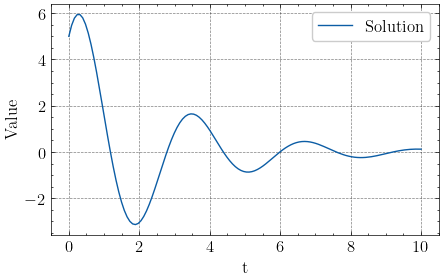

In [8]:
# Default problem. Just beautiful dynamics.
T = 10
zeta, omega = 0.2, 2.0
x_0, v_0 = 5.0, 7.0
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
plot_ode(problem.t.numpy(), [(problem.solution, 'Solution', None)], size=(5,3))

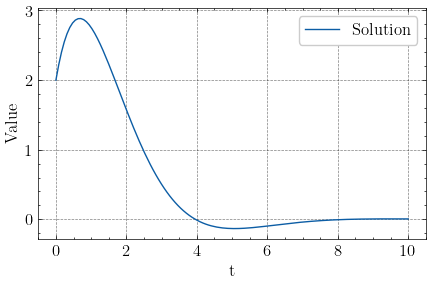

In [47]:
# When changing v_0 in this case, the solution function does not change it's 
# behavior and looks the same. Only thing that changes - magnitude of it's values

T = 10
zeta, omega = 0.7, 1.0
x_0, v_0 = 2.0, 3.0
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
plot_ode(problem.t.numpy(), [(problem.solution, 'Solution', None)], size=(5,3))

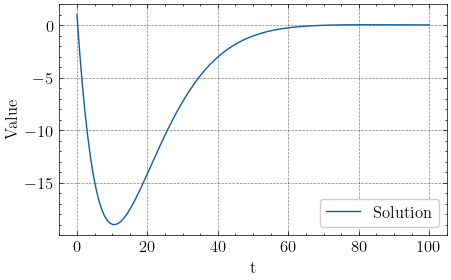

In [41]:
# This case is easy, but T is large.
T = 100
zeta, omega = 0.9, 0.1
x_0, v_0 = 1.0, -5.0
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
plot_ode(problem.t.numpy(), [(problem.solution, 'Solution', None)], size=(5,3))

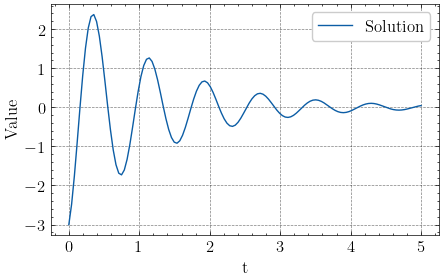

In [52]:
# This case is very dynamical. Required L, W, N_D perhaps should raise very much.
T = 5
zeta, omega = 0.1, 8
x_0, v_0 = -3.0, 10.
problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
plot_ode(problem.t.numpy(), [(problem.solution, 'Solution', None)], size=(5,3))

In [55]:
def get_problem(N):
    match N:
        case 1:
            T = 10
            zeta, omega = 0.2, 2.0
            x_0, v_0 = 5.0, 7.0
        case 2:
            T = 10
            zeta, omega = 0.7, 1.0
            x_0, v_0 = 2.0, 3.0
        case 3:
            T = 100
            zeta, omega = 0.9, 0.1
            x_0, v_0 = 1.0, -5.0
        case 4:
            T = 5
            zeta, omega = 0.1, 8
            x_0, v_0 = -3.0, 10.
    
    problem = DampedHarmonicOscillator(T, (zeta, omega), (x_0, v_0))
    
    return problem

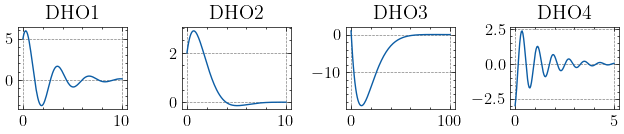

In [80]:
problems = [get_problem(i) for i in range(1, 5)]

size = (10*0.65, 2 * 0.8)
fig, axs = plt.subplots(1, 4, figsize=size)
for i, problem in enumerate(problems):
    axs[i].plot(problem.t, problem.solution)
    axs[i].title.set_text(f'DHO{i+1}')
plt.tight_layout()

plt.savefig('../images/dho_grid.png', dpi=250)
plt.show()

In [ ]:
problem = get_problem(3)
test_model = torch.load('./studies/dho_2_best_model.pt', map_location='cpu')
predictions = test_model(problem.t.reshape(-1, 1)).detach().flatten().numpy()
plot_ode(
    problem.t.numpy(), 
    predicted=[(predictions, 'Neural Network', None)], 
    solutions=[(problem.solution, 'Numerical Solution', None)], 
    size=(5, 3)
    )

## Hyperparameter tuning
---

In [11]:
import optuna

best_model = None
model = None

def objective(trial):
    
    global model
    
    L = trial.suggest_int('L', 2, 8, step=2)
    W = trial.suggest_int('W', 32, 64, step=16)
    model = FeedForwardNetwork(L, W, input_dim=1, output_dim=1).to(device)
    
    N_D = trial.suggest_int('N_D', 64, 2048, log=True)
    coef = trial.suggest_float('coef', 0.05, 0.95)
    
    lr = trial.suggest_float('lr', 1e-5, 1.0, log=True)
    
    sampling = trial.suggest_categorical('sampling', ['random', 'grid'])
    
    if sampling == 'random':
        collocation_points = torch.tensor(np.random.uniform(0, problem.T, N_D), dtype=torch. float32, requires_grad=True).reshape(-1, 1).to(device)
    else:
        collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    for i in range(7500):
        
        optim.zero_grad()
        
        L_I = problem.loss_initial(model)
        L_D = problem.loss_physical(model, collocation_points)
    
        L = coef * L_I + (1 - coef) * L_D
        
        L.backward()
        optim.step()
        
        if (i + 1) % 500 == 0:
            predicts = model(problem.t.reshape(-1, 1)).flatten().detach().cpu().numpy()
            error = l2(predicts, problem.solution)
            
            trial.report(error, i + 1)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
            
    return error

def callback(study, trial):
    global best_model
    
    if study.best_trial == trial:
        best_model = model

c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
for problem_number in range(3, 5):
    problem = get_problem(problem_number)

    study = optuna.create_study(
        study_name=f'dho_{problem_number}',
        direction='minimize',
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(max_resource=7500)
        )

    study.optimize(objective, n_trials=50, callbacks=[callback])
    study.trials_dataframe().to_csv(f'./studies/{study.study_name}.csv', sep=',')
        
    torch.save(best_model, f'./studies/{study.study_name}_best_model.pt')

[I 2024-04-02 21:53:10,198] A new study created in memory with name: dho_3
[I 2024-04-02 21:54:36,715] Trial 0 finished with value: 1.9327426579575246 and parameters: {'L': 4, 'W': 64, 'N_D': 369, 'coef': 0.15402911550283904, 'lr': 0.00047038591622965506, 'sampling': 'grid'}. Best is trial 0 with value: 1.9327426579575246.
[I 2024-04-02 21:54:50,276] Trial 1 pruned. 
[I 2024-04-02 21:55:35,820] Trial 2 finished with value: 84.27149955307704 and parameters: {'L': 4, 'W': 48, 'N_D': 65, 'coef': 0.78180842661031, 'lr': 0.00431158651250875, 'sampling': 'grid'}. Best is trial 0 with value: 1.9327426579575246.
[I 2024-04-02 21:56:41,460] Trial 3 pruned. 
[I 2024-04-02 21:56:51,432] Trial 4 pruned. 
[I 2024-04-02 21:56:59,827] Trial 5 pruned. 
[I 2024-04-02 21:57:13,398] Trial 6 pruned. 
[I 2024-04-02 21:57:22,258] Trial 7 pruned. 
[I 2024-04-02 22:00:30,808] Trial 8 finished with value: 97.729804662806 and parameters: {'L': 8, 'W': 48, 'N_D': 1221, 'coef': 0.4299245159539406, 'lr': 0.2383279

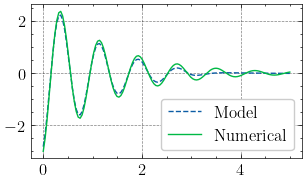

In [185]:
problem = get_problem(4)
test_model = torch.load('./studies/dho_4_best_model.pt', map_location='cpu')
predictions = test_model(problem.t.reshape(-1, 1)).detach().flatten().cpu().numpy()

fig = plt.figure(figsize=(3.5, 2))
plt.plot(problem.t, predictions, label='Model', linestyle='dashed')
plt.plot(problem.t, problem.solution, label='Numerical')
plt.legend()
plt.savefig('../images/dho_4_solution.png', dpi=250)

## Hyperparameters analysis
---

In [81]:
import pandas as pd
from datetime import datetime

In [82]:
new_names = ['l2', 'duration', 'L', 'N_D', 'W', 'C', 'lr', 'sampling', 'state']

def convert(duration):
    pt = datetime.strptime(duration[duration.find('days')+5:],'%H:%M:%S.%f')
    return pt.second + pt.minute*60 + pt.hour*3600

rungs = [f'system_attrs_completed_rung_{i}' for i in range(8)]
dho1 = pd.read_csv('./studies/dho_1.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rungs, axis=1)
dho2 = pd.read_csv('./studies/dho_2.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rungs, axis=1)
dho3 = pd.read_csv('./studies/dho_3.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rungs, axis=1)
dho4 = pd.read_csv('./studies/dho_4.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rungs, axis=1)

for df in [dho1, dho2, dho3, dho4]:
    df.columns = new_names
    df['duration'] = df['duration'].apply(convert)

In [83]:
dho1.sort_values('l2').head()

,l2,duration,L,N_D,W,C,lr,sampling,state
48,0.127620,51,2,837,64,0.375677,0.003591,grid,COMPLETE
31,0.135157,52,2,201,64,0.420306,0.005862,grid,COMPLETE
32,0.155473,49,2,240,64,0.402518,0.005755,grid,COMPLETE
30,0.200619,52,2,214,64,0.419656,0.006118,grid,COMPLETE
35,0.382494,45,2,483,64,0.353402,0.034705,grid,COMPLETE


In [84]:
dho2.sort_values('l2').head()

,l2,duration,L,N_D,W,C,lr,sampling,state
4,0.016395,52,2,522,48,0.143011,0.000482,grid,COMPLETE
31,0.037440,115,6,1042,48,0.284018,0.000265,grid,COMPLETE
18,0.042041,141,8,248,48,0.206684,0.000363,random,COMPLETE
15,0.042178,143,8,263,48,0.183904,0.000406,grid,COMPLETE
5,0.045164,115,6,1359,48,0.439429,0.000222,grid,COMPLETE


In [85]:
dho3.sort_values('l2').head()

,l2,duration,L,N_D,W,C,lr,sampling,state
0,1.932743,86,4,369,64,0.154029,0.000470,grid,COMPLETE
11,72.551020,57,6,456,64,0.247211,0.000301,random,PRUNED
18,72.709951,3,2,249,48,0.368521,0.000117,random,PRUNED
48,72.748635,8,4,488,64,0.201001,0.000213,grid,PRUNED
23,72.778898,3,2,177,64,0.759462,0.002264,grid,PRUNED


In [86]:
dho4.sort_values('l2').head()

,l2,duration,L,N_D,W,C,lr,sampling,state
15,1.126346,31,2,232,32,0.919807,0.013386,grid,COMPLETE
22,1.786107,43,2,787,32,0.851848,0.018678,grid,COMPLETE
30,2.612120,60,4,283,32,0.802192,0.004521,grid,COMPLETE
13,3.365808,35,2,626,32,0.759663,0.012762,grid,COMPLETE
42,4.415887,35,2,284,32,0.756251,0.004939,grid,COMPLETE


In [105]:
dho1['l2'].corr(dho1['lr'])

0.45691527519065755

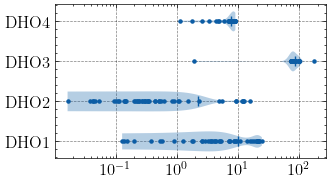

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

data = [df['l2'].to_numpy() for df in [dho1, dho2, dho3, dho4]]

ax.violinplot(
    [df['l2'].to_numpy() for df in [dho1, dho2, dho3, dho4]],
    showextrema=False, showmeans=True, vert=False
)
ax.set_yticks(ticks=[1, 2, 3, 4], labels=['DHO1', 'DHO2', 'DHO3', 'DHO4'])
ax.set_xscale('log')
ax.scatter(
    x=data,
    y=[np.ones(50)*i for i in range(1, 5)], 
    s=5
)

plt.savefig('../images/dho_violins.png', dpi=250)

plt.show()